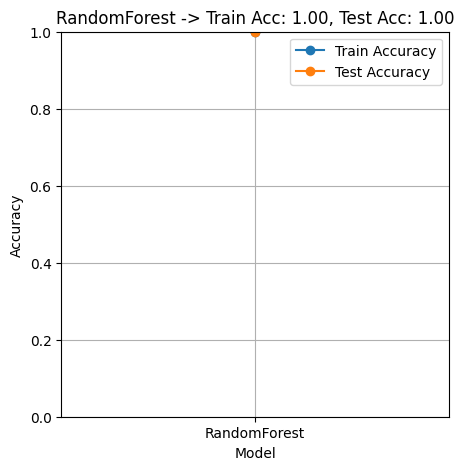

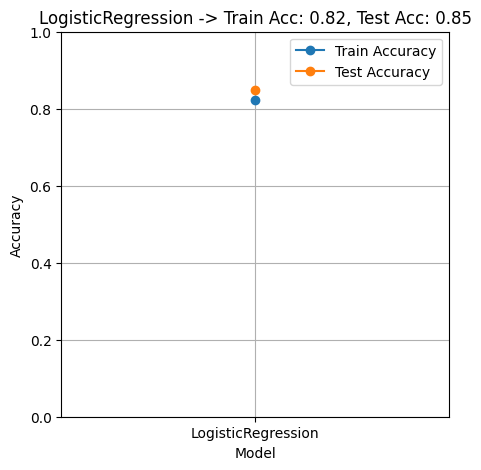

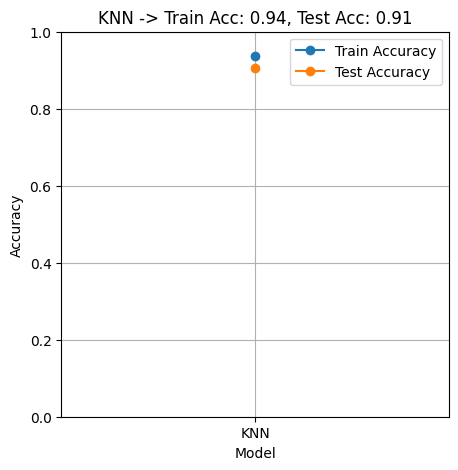

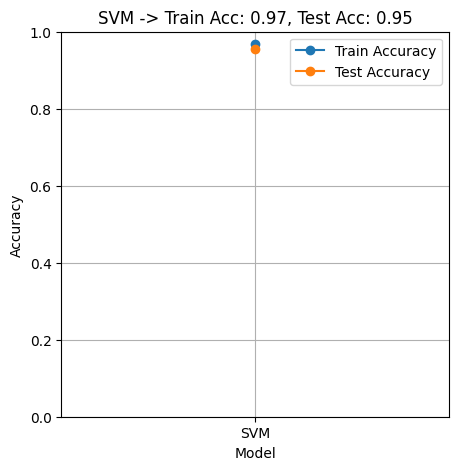

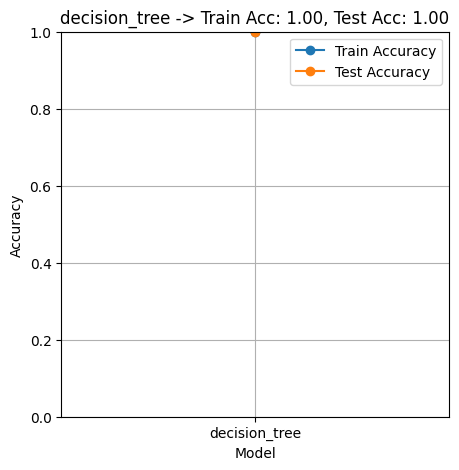

RandomForest -> Accuracy: 1.00, F1-score: 1.00, Recall: 1.00
LogisticRegression -> Accuracy: 0.85, F1-score: 0.85, Recall: 0.85
KNN -> Accuracy: 0.91, F1-score: 0.90, Recall: 0.91
SVM -> Accuracy: 0.95, F1-score: 0.95, Recall: 0.95
decision_tree -> Accuracy: 1.00, F1-score: 1.00, Recall: 1.00


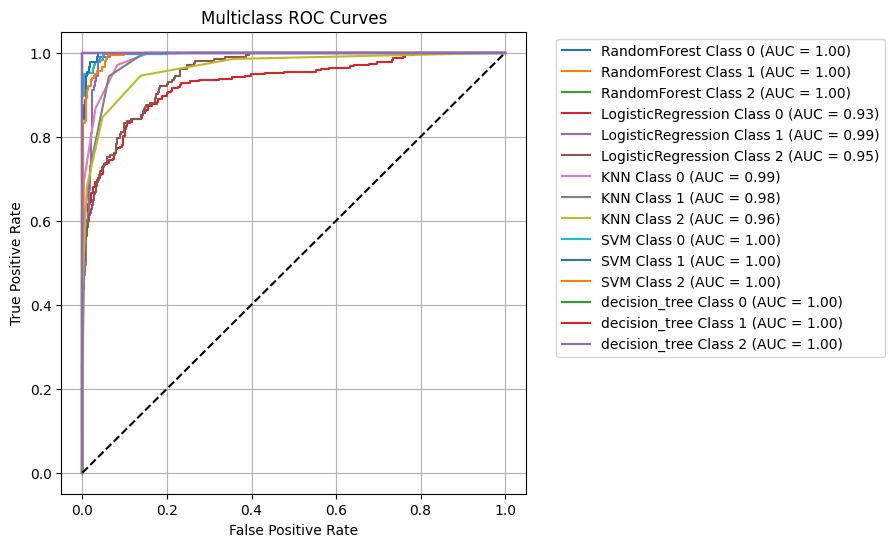

Prediction : [1]


,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level,Stress_Level_Encoded
0,6.9,3.8,8.7,2.8,1.8,2.99,Moderate,2
1,5.3,3.5,8.0,4.2,3.0,2.75,Low,1
2,5.1,3.9,9.2,1.2,4.6,2.67,Low,1
3,6.5,2.1,7.2,1.7,6.5,2.88,Moderate,2
4,8.1,0.6,6.5,2.2,6.6,3.51,High,0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, RocCurveDisplay, confusion_matrix, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import joblib

# Etape 1 : Load dataset from kaggle
df = pd.read_csv("student_lifestyle_dataset.csv")

# Etape 2 : cleaning the data
df = df.drop(columns=['Student_ID'])

le = LabelEncoder()
df['Stress_Level_Encoded'] = le.fit_transform(df['Stress_Level'])
y = df['Stress_Level_Encoded']
X = df.drop(columns=['Stress_Level', 'Stress_Level_Encoded'])

# Etape 3 : Train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

rf = RandomForestClassifier()
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
knn = KNeighborsClassifier()
svm = SVC(probability=True)
dt = DecisionTreeClassifier()

models = {
    "RandomForest": rf,
    "LogisticRegression": lr,
    "KNN": knn,
    "SVM": svm,
    "decision_tree": dt
}

# Etape 4 : Evaluation

# Function to check under/overfitting
def checkUnderAndOverfitting(models):

  for name, model in models.items():
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    plt.figure(figsize=(5,5))
    plt.plot(name, train_acc, marker='o', label='Train Accuracy', linestyle='-')
    plt.plot(name, test_acc, marker='o', label='Test Accuracy', linestyle='-')
    plt.title(f"{name} -> Train Acc: {train_acc:.2f}, Test Acc: {test_acc:.2f}")
    plt.ylabel("Accuracy")
    plt.xlabel("Model")
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend()
    plt.show()

checkUnderAndOverfitting(models)

y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

def plot(models):
  for name, model in models.items():
    model.fit(x_train, y_train)

    if hasattr(model, "predict_proba"):
        y_pred = np.argmax(model.predict_proba(x_test), axis=1)
    elif hasattr(model, "decision_function"):
        y_pred = np.argmax(model.decision_function(x_test), axis=1)
    y_pred = model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    print(f"{name} -> Accuracy: {acc:.2f}, F1-score: {f1:.2f}, Recall: {rec:.2f}")

plot(models)

def plot_roc(models):
    plt.figure(figsize=(6,6))

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(x_test)
        else:
            y_score = model.decision_function(x_test)

        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0,1],[0,1],'k--')
    plt.title("Multiclass ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()
plot_roc(models)

# Etape 5 : Production (using random forest)
final_model = dt
joblib.dump(final_model, "stress_quality.pkl")
joblib.dump(scaler, "stress_scaler.pkl")
joblib.dump(le, "stress_le.pkl")

new_data = pd.DataFrame([[5.3,	3.5,	8,	4.2,	3,	2.75 	]], columns=["Study_Hours_Per_Day","Extracurricular_Hours_Per_Day","Sleep_Hours_Per_Day","Social_Hours_Per_Day","Physical_Activity_Hours_Per_Day","GPA"])

new_data_scaled = scaler.transform(new_data)

y_preds = final_model.predict(new_data_scaled)
print(f"Prediction : {y_preds}")

df.head()

# "Study_Hours_Per_Day", "Extracurricular_Hours_Per_Day", "Sleep_Hours_Per_Day", "Social_Hours_Per_Day", "Physical_Activity_Hours_Per_Day", "GPA"]